# Classification

After determining which bit offsets are relevant for the I/O, we try to develop a classifier which can distinguish between different I/O standards.

In [1]:
import zipfile
import os
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.tree import DecisionTreeClassifier

from JicBitstream import JicBitstream, JicBitstreamZip
from knowledge import PU_ADDR
from knowledge2 import BLK_LOC_START_BIT, UNKNW_BLK_LOWER_LIM, UNKWN_BLK_NR

%matplotlib notebook

In [2]:
IOSTD_REL_TO_PU = np.array(
    [
        -512,
        -480,
        -448,
        -416,
        -384,
        -352,
        -320,
        -288,
        -256,
        -224,
        -192,
        -160,
        -128,
        -96,
        -64,
        -32,
        0,
        256,
        288,
        512,
        544,
        864,
        1504,
        1536,
        1600,
    ]
)

In [3]:
def offs_cor(addr, pin):
    addr -= np.sum(addr > BLK_LOC_START_BIT) * 64
    unknw_blk_lower_lim = UNKNW_BLK_LOWER_LIM[pin]
    unknw_blk_nr = UNKWN_BLK_NR[pin]

    if addr > unknw_blk_lower_lim:
        addr -= unknw_blk_nr * 1344

    return addr


def offs_cor_reverse(addr, pin):
    orig_addr = addr
    unknw_blk_lower_lim = UNKNW_BLK_LOWER_LIM[pin]
    unknw_blk_nr = UNKWN_BLK_NR[pin]

    if addr > unknw_blk_lower_lim:
        addr += unknw_blk_nr * 1344

    est_addr = addr + (np.sum(addr > BLK_LOC_START_BIT) * 64)
    est_addr = addr + (np.sum(est_addr > BLK_LOC_START_BIT) * 64)
    addr += np.sum(est_addr > BLK_LOC_START_BIT) * 64

    return addr

def get_indices(arr, vals):
    idxs = []
    for val in vals:
        idxs.append(np.where(arr == val)[0][0])
    return np.array(idxs)

In [4]:
pin = "R32"
pin_dis = "A32"

jics = [
    (f"{pin}_2V5_16mA_pu_off_dly_no.zip", "../../results/out/", None),
    (f"{pin}_2V5_12mA_pu_off_dly_no.zip", "../../results/out/", None),
    (f"{pin}_2V5_8mA_pu_off_dly_no.zip", "../../results/out/", None),
    (f"{pin}_2V5_4mA_pu_off_dly_no.zip", "../../results/out/", None),
    (f"{pin}_2V5_16mA_pu_on_dly_no.zip", "../../results/out/", None),
    (f"{pin}_2V5_12mA_pu_on_dly_no.zip", "../../results/out/", None),
    (f"{pin}_2V5_8mA_pu_on_dly_no.zip", "../../results/out/", None),
    (f"{pin}_2V5_4mA_pu_on_dly_no.zip", "../../results/out/", None),
    (f"{pin}_sstl15_default.zip", "../../results/out/", None),
    (f"{pin}_sstl15_class1_default.zip", "../../results/out/", None),
    (f"{pin}_sstl15_class2_default.zip", "../../results/out/", None),
    (f"{pin}_sstl15_class1_term_off_12mA.zip", "../../results/out/", None),
    (f"{pin}_sstl15_class1_term_off_10mA.zip", "../../results/out/", None),
    (f"{pin}_sstl15_class1_term_off_8mA.zip", "../../results/out/", None),
    (f"{pin}_sstl15_class1_term_off_6mA.zip", "../../results/out/", None),
    (f"{pin}_sstl15_class2_term_off_16mA.zip", "../../results/out/", None),
    (f"{pin}_sstl15_class2_term_off_8mA.zip", "../../results/out/", None),
    (f"{pin_dis}_2V5_16mA_pu_off_dly_no.zip", "../../results/out/", "disabled"),
    (f"{pin_dis}_2V5_4mA_pu_off_dly_no.zip", "../../results/out/", "disabled"),
    (f"{pin}_2V5.zip", "../../results/in/", None),
    (f"{pin}_sstl15_class2.zip", "../../results/in/", None),
    (f"{pin}_sstl15_class2_term_par50.zip", "../../results/in/", None),
    (f"{pin}_2V5_16mA_pu_off_dly_no.zip", "../../results/bidir/", None),
    (f"{pin}_2V5_12mA_pu_off_dly_no.zip", "../../results/bidir/", None),
    (f"{pin}_2V5_8mA_pu_off_dly_no.zip", "../../results/bidir/", None),
    (f"{pin}_2V5_4mA_pu_off_dly_no.zip", "../../results/bidir/", None),
    (f"{pin}_sstl15_default.zip", "../../results/bidir/", None),
    (f"{pin}_sstl15_class1_default.zip", "../../results/bidir/", None),
    (f"{pin}_sstl15_class2_default.zip", "../../results/bidir/", None),
    (f"{pin_dis}_sstl15_default.zip", "../../results/bidir/", "disabled"),
    (f"{pin_dis}_sstl15_default.zip", "../../results/bidir/", "disabled"),
]

feat_addrs = IOSTD_REL_TO_PU + offs_cor(PU_ADDR[pin], pin)
feat_addrs = np.array([offs_cor_reverse(addr, pin) for addr in feat_addrs])

feats = []
labels = []

idxs_oi = get_indices(
    IOSTD_REL_TO_PU,
    [-256, -224, 544],
)
print(idxs_oi)

for jic, jic_path, label in jics:
    j = JicBitstreamZip(os.path.join(jic_path, jic))

    feat = j.get_els(feat_addrs).astype(int)
    feats.append(feat)

    io_dir = jic_path.split("/")[-2]
    if label is None:
        label = io_dir + "_" + jic.replace(f"{pin}_", "").replace(".zip", "")
    labels.append(label)

    dis_or_io_dir = "dis" if label == "disabled" else io_dir
    print(f"{jic.replace('.zip', ''):32} {dis_or_io_dir:5}", end=" ")
    print(np.any(feat[idxs_oi]) * 1, feat[idxs_oi], end=" ")
    print(feat)

[ 8  9 20]
R32_2V5_16mA_pu_off_dly_no       out   0 [0 0 0] [0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 1 1]
R32_2V5_12mA_pu_off_dly_no       out   0 [0 0 0] [0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 1 1]
R32_2V5_8mA_pu_off_dly_no        out   0 [0 0 0] [0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1]
R32_2V5_4mA_pu_off_dly_no        out   0 [0 0 0] [0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 1]
R32_2V5_16mA_pu_on_dly_no        out   0 [0 0 0] [0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0 0 1 1 1]
R32_2V5_12mA_pu_on_dly_no        out   0 [0 0 0] [0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1]
R32_2V5_8mA_pu_on_dly_no         out   0 [0 0 0] [0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 1 1]
R32_2V5_4mA_pu_on_dly_no         out   0 [0 0 0] [0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 1 1 1]
R32_sstl15_default               out   1 [0 0 1] [0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0]
R32_sstl15_class1_default        out   1 [1 1 0] [1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 

## Decision-tree classifier for the pin standard

After we have narrowed down which bits are responsible only for the output, we train a classifier to distinguish between different standards.

In [5]:
pin = "R32"
pin_dis = "A32"

IDX_OUT_DT = np.array(
    [-512, -480, -416, -384, -320, -288, -256, -224, -192, -160, -128, 544]
)

jics = [
    (f"{pin}_2V5_16mA_pu_off_dly_no.zip", "../../results/out/", ["2V5", 3]),
    (f"{pin}_2V5_12mA_pu_off_dly_no.zip", "../../results/out/", ["2V5", 2]),
    (f"{pin}_2V5_8mA_pu_off_dly_no.zip", "../../results/out/", ["2V5", 1]),
    (f"{pin}_2V5_4mA_pu_off_dly_no.zip", "../../results/out/", ["2V5", 0]),
    (f"{pin}_2V5_16mA_pu_on_dly_no.zip", "../../results/out/", ["2V5", 3]),
    (f"{pin}_2V5_12mA_pu_on_dly_no.zip", "../../results/out/", ["2V5", 2]),
    (f"{pin}_2V5_8mA_pu_on_dly_no.zip", "../../results/out/", ["2V5", 1]),
    (f"{pin}_2V5_4mA_pu_on_dly_no.zip", "../../results/out/", ["2V5", 0]),
    (f"{pin}_2V5_16mA_pu_off_dly_no.zip", "../../results/bidir/", ["2V5", 3]),
    (f"{pin}_2V5_12mA_pu_off_dly_no.zip", "../../results/bidir/", ["2V5", 2]),
    (f"{pin}_2V5_8mA_pu_off_dly_no.zip", "../../results/bidir/", ["2V5", 1]),
    (f"{pin}_2V5_4mA_pu_off_dly_no.zip", "../../results/bidir/", ["2V5", 0]),
    (f"{pin}_sstl15_default.zip", "../../results/out/", ["S", 5]),
    (f"{pin}_sstl15_class1_default.zip", "../../results/out/", ["Scls1", 6]),
    (f"{pin}_sstl15_class2_default.zip", "../../results/out/", ["Scls2", 7]),
    (f"{pin}_sstl15_default.zip", "../../results/bidir/", ["S", 5]),
    (f"{pin}_sstl15_class1_default.zip", "../../results/bidir/", ["Scls1", 6]),
    (f"{pin}_sstl15_class2_default.zip", "../../results/bidir/", ["Scls2", 7]),
    (f"{pin}_sstl15_class1_term_off_12mA.zip", "../../results/out/", ["Scls1", 11]),
    (f"{pin}_sstl15_class1_term_off_10mA.zip", "../../results/out/", ["Scls1", 10]),
    (f"{pin}_sstl15_class1_term_off_8mA.zip", "../../results/out/", ["Scls1", 9]),
    (f"{pin}_sstl15_class1_term_off_6mA.zip", "../../results/out/", ["Scls1", 8]),
    (f"{pin}_sstl15_class2_term_off_16mA.zip", "../../results/out/", ["Scls2", 13]),
    (f"{pin}_sstl15_class2_term_off_8mA.zip", "../../results/out/", ["Scls2", 12]),
]

feat_addrs = IOSTD_REL_TO_PU + offs_cor(PU_ADDR[pin], pin)
feat_addrs = np.array([offs_cor_reverse(addr, pin) for addr in feat_addrs])

feats = []
labels = []

idxs_oi = get_indices(IOSTD_REL_TO_PU, IDX_OUT_DT)
print(idxs_oi)


for jic, jic_path, label in jics:
    j = JicBitstreamZip(os.path.join(jic_path, jic))

    feat = j.get_els(feat_addrs).astype(int)
    feat = feat[idxs_oi]
    feats.append(feat)

    io_dir = jic_path.split("/")[-2]
    labels.append(label)

    dis_or_io_dir = "dis" if label == "disabled" else io_dir
    print(f"{jic.replace('.zip', ''):32} {dis_or_io_dir:5}", end=" ")
    print(label, end=" ")
    print(feat)

[ 0  1  3  4  6  7  8  9 10 11 12 20]
R32_2V5_16mA_pu_off_dly_no       out   ['2V5', 3] [0 0 1 0 0 1 0 0 0 0 1 0]
R32_2V5_12mA_pu_off_dly_no       out   ['2V5', 2] [0 0 1 0 1 0 0 0 1 1 0 0]
R32_2V5_8mA_pu_off_dly_no        out   ['2V5', 1] [0 0 1 0 1 0 0 0 0 1 0 0]
R32_2V5_4mA_pu_off_dly_no        out   ['2V5', 0] [0 0 0 0 0 0 0 0 1 0 0 0]
R32_2V5_16mA_pu_on_dly_no        out   ['2V5', 3] [0 0 1 0 0 1 0 0 0 0 1 0]
R32_2V5_12mA_pu_on_dly_no        out   ['2V5', 2] [0 0 1 0 1 0 0 0 1 1 0 0]
R32_2V5_8mA_pu_on_dly_no         out   ['2V5', 1] [0 0 1 0 1 0 0 0 0 1 0 0]
R32_2V5_4mA_pu_on_dly_no         out   ['2V5', 0] [0 0 0 0 0 0 0 0 1 0 0 0]
R32_2V5_16mA_pu_off_dly_no       bidir ['2V5', 3] [0 1 1 0 1 0 0 0 0 0 1 0]
R32_2V5_12mA_pu_off_dly_no       bidir ['2V5', 2] [0 1 1 0 1 0 0 0 0 0 1 0]
R32_2V5_8mA_pu_off_dly_no        bidir ['2V5', 1] [0 1 1 0 1 0 0 0 0 0 1 0]
R32_2V5_4mA_pu_off_dly_no        bidir ['2V5', 0] [0 1 1 0 1 0 0 0 0 0 1 0]
R32_sstl15_default               out   ['S', 5] [0

[0.         0.1285347  0.10329516 0.21722365 0.08226221 0.05755684
 0.         0.         0.1285347  0.08226221 0.04113111 0.15919941]


<IPython.core.display.Javascript object>


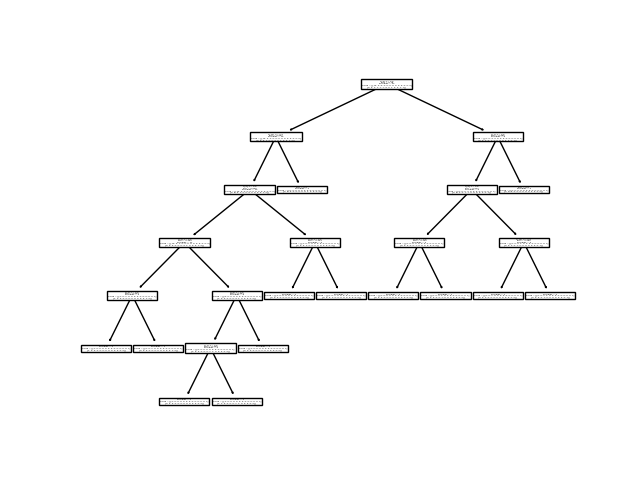

In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

X = np.array(feats)
y = np.array(labels)

out_std_dtc = DecisionTreeClassifier(random_state=1234)
out_std_dtc.fit(X, y)
print(out_std_dtc.feature_importances_)
plot_tree(out_std_dtc)

import pickle
pickle.dump(out_std_dtc, open("out_std_dtc.p", "wb"))
pickle.dump(IDX_OUT_DT, open("IDX_OUT_DT.p", "wb"))

None

In [7]:
class IOclassifier:
    IDX_PU = 0
    IDX_INPUT_ACT_B = 288

    # output will have at least one of those set, input will have all zeros
    IDX_OUTPUT = [-512, -480, -416, -384, -320, -288, -256, -224, -192, -160, -128, 544]

    # [0, 0, 1] = def, [1, 1 0] = class 1 or 2
    IDX_SSTL_TERM = [-256, -224, 544]

    @staticmethod
    def _offs_cor(addr, pin):
        addr -= np.sum(addr > BLK_LOC_START_BIT) * 64
        unknw_blk_lower_lim = UNKNW_BLK_LOWER_LIM[pin]
        unknw_blk_nr = UNKWN_BLK_NR[pin]

        if addr > unknw_blk_lower_lim:
            addr -= unknw_blk_nr * 1344

        return addr

    @staticmethod
    def _offs_cor_reverse(addr, pin):
        orig_addr = addr
        unknw_blk_lower_lim = UNKNW_BLK_LOWER_LIM[pin]
        unknw_blk_nr = UNKWN_BLK_NR[pin]

        if addr > unknw_blk_lower_lim:
            addr += unknw_blk_nr * 1344

        est_addr = addr + (np.sum(addr > BLK_LOC_START_BIT) * 64)
        est_addr = addr + (np.sum(est_addr > BLK_LOC_START_BIT) * 64)
        addr += np.sum(est_addr > BLK_LOC_START_BIT) * 64

        return addr

    @staticmethod
    def get_indices(arr, vals):
        idxs = []
        for val in vals:
            idxs.append(np.where(arr == val)[0][0])
        return np.array(idxs)

    def __init__(self, idx_vec, idx_dtree_out, dtree_out):
        self.idx_vec = idx_vec
        self.IDX_OUT_DT = idx_dtree_out
        self.dtree_out = dtree_out

    def classify(self, jic: JicBitstream, pin_lst):
        for pin in pin_lst:
            self._classify_pin(feat, pin)

    def _classify_pin(self, feat, pin):
        feat_addrs = IOSTD_REL_TO_PU + self._offs_cor(PU_ADDR[pin], pin)
        feat_addrs = np.array(
            [self._offs_cor_reverse(addr, pin) for addr in feat_addrs]
        )
        feat = jic.get_els(feat_addrs).astype(int)
        has_pu = self._has_pull_up(feat)
        has_output = self._has_output(feat)
        has_input = self._has_output(feat)
        print(f"has pull up: {has_pu}")
        print(f"has output: {has_output}")
        print(f"has input: {has_input}")
        if has_output:
            io_std = self._get_iostd(feat)
            print(io_std)
            if io_std[0][0] == "S":
                sstl_term = self._get_sstl_term(feat)
                print(sstl_term)

    def _has_pull_up(self, feat):
        pu_idx = np.where(self.idx_vec == self.IDX_PU)[0][0]
        print(pu_idx)
        return bool(feat[pu_idx])

    def _has_output(self, feat):
        out_idxs = self.get_indices(self.idx_vec, self.IDX_OUTPUT)
        return np.any(feat[out_idxs])

    def _has_input(self, feat):
        in_idx = np.where(self.idx_vec == self.IDX_INPUT_ACT_B)[0][0]
        return not bool(feat[pu_idx])

    def _get_iostd(self, feat):
        idxs_iostd = self.get_indices(self.idx_vec, self.IDX_OUT_DT)
        feat_iostd = feat[idxs_iostd]
        print(feat_iostd)
        return self.dtree_out.predict(feat_iostd.reshape(1, -1))[0]

    def _get_sstl_term(self, feat):
        idxs_sstl_term = self.get_indices(self.idx_vec, self.IDX_SSTL_TERM)
        feat_sstl_term = feat[idxs_sstl_term]
        DEF_TERM = np.array([0, 0, 1])
        CL1_2_TERM = np.array([1, 1, 0])
        if np.array_equal(feat_sstl_term, DEF_TERM):
            return "SSTL, term"
        elif np.array_equal(feat_sstl_term, CL1_2_TERM):
            return "SSTL cl1/2, term"
        else:
            return "no term"


jic = JicBitstreamZip(f"../../results/out/R32_2V5_16mA_pu_on_dly_no.zip")
iocls = IOclassifier(IOSTD_REL_TO_PU, IDX_OUT_DT, out_std_dtc)
iocls.classify(jic, ["R32"])

16
has pull up: True
has output: True
has input: True
[0 0 1 0 0 1 0 0 0 0 1 0]
['2V5' '3']
